# Return Prediction with High-Dimensional Data (II)

#### Equity premium prediction with the Goyal & Welch dataset

The PredictorData.xls file can be downloaded from Amit Goyal's website:
https://docs.google.com/spreadsheets/d/1bM7vCWd3WOt95Sf9qjLPZjoiafgF_8EG/edit?gid=407859737#gid=407859737

In [12]:
# Import necessary libraries
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error, mean_absolute_error

import statsmodels.api as sm

import ssl
ssl._create_default_https_context = ssl._create_stdlib_context


In [13]:
# Setting a seed for reproducibility
np.random.seed(0)
random.seed(0)

## Preprocessing

#### Step 1: Download the Data

In [14]:
# Retrieve the data
def load_data():
    xls_path = 'PredictorData2023.xlsx'

    goyal = pd.ExcelFile(xls_path)
    df = {sheet_name: goyal.parse(sheet_name) for sheet_name in goyal.sheet_names}

    df['Monthly']['yyyymm'] = pd.to_datetime(df['Monthly']['yyyymm'].astype(str), format='%Y%m')
    df['Monthly'].set_index('yyyymm', inplace=True)
    df['Monthly'].index = df['Monthly'].index.to_period('M').to_timestamp('M')


    # create date index for annual data
    df['Annual']['yyyy'] = pd.to_datetime(df['Annual']['yyyy'].astype(str), format='%Y')
    df['Annual'].set_index('yyyy', inplace=True)
    df['Annual'].index = df['Annual'].index.to_period('Y').to_timestamp('Y')

    df = df['Monthly']

    return df

#### Step 2: Transform the Data

In [15]:
def transxf(df):

    # Dividend Price Ratio (d/p) is the difference between the log of dividends and the log of prices.
    df['d/p'] = np.log(df['D12']) - np.log(df['Index'])

    # Dividend Yield (d/y) is the difference between the log of dividends and the log of lagged prices.
    df['d/y'] = np.log(df['D12'])- np.log(df['Index'].shift(1))

    # Earnings Price Ratio (e/p) is the difference between the log of earnings and the log of prices.
    df['e/p'] = np.log(df['E12']) - np.log(df['Index'])

    # Dividend Payout Ratio (d/e) is the difference between the log of dividends and the log of earnings.
    df['d/e'] = np.log(df['D12']) - np.log(df['E12'])

    # Term Spread (tms) is the difference between the long term yield on government bonds and the T-bill.
    df['tms'] = df['lty'] - df['tbl']

    # Default Yield Spread (dfy): is the difference between BAA- and AAA- rated corporate bond yields.
    df['dfy'] = df['BAA'] - df['AAA']

    # Default Return Spread (dfr): is the difference between the return on long-term corporate bonds and returns on the long-term government bonds.
    df['dfr'] = df['corpr'] - df['ltr']

    # Calculate Index Price plus Dividends
    df['IndexDiv'] = df['Index'] + df['D12']

    # Calculate logretdiv (log return with dividends)
    df['logretdiv'] = np.log(df['IndexDiv'] / df['Index'].shift(1))

    # Calculate logRfree
    df['logRfree'] = np.log(df['Rfree'] + 1)

    # equity premium, i.e., the total rate of return on the stock market minus the prevailing short-term interest rate.
    df['premium'] = df['logretdiv'] - df['logRfree']

    df = df.drop(columns=['Index', 'csp', 'D12', 'E12', 'AAA', 'BAA', 'CRSP_SPvwx', 'corpr','Rfree', 'CRSP_SPvw'])

    return df

#### Step 3: Define the Target Variable 

In [16]:
# Define the target variable (S&P 500 Returns)
def preprocess_data(df):
    """
    Preprocess the data by creating the target variable (S&P 500 log returns) and removing NaNs.

    Args:
    df (DataFrame): Data containing S&P 500 returns.

    Returns:
    DataFrame: Processed data with target variable.
    """
    df['Target'] = df['premium'].shift(periods=-1)
    df.drop(['premium'], axis=1, inplace=True)
    df = df.apply(lambda x: x.fillna(x.rolling(window=6, min_periods=1).mean()))
    df.dropna(inplace=True)

    return df

## Estimating the Models

In [17]:
# Estimating the Forecasting Models
def train_models(train_data_scaled, train_pca, input_dim):
    """
    Train multiple forecasting models (OLS, LASSO, Decision Tree, Random Forest, and Neural Network).

    Args:
    train_data_scaled (DataFrame): Scaled training data.
    train_pca (DataFrame): Training data after applying PCA.
    input_dim (int): Input dimension for the neural network model.

    Returns:
    Dict: Trained models.
    """
    models = {
        'ols': LinearRegression(fit_intercept=True).fit(train_data_scaled.drop("Target", axis=1),
                                                        train_data_scaled["Target"]),
        'ols_pca': LinearRegression(fit_intercept=True).fit(train_pca, train_data_scaled["Target"]),
        'lasso': Lasso(alpha=0.005, fit_intercept=True).fit(train_data_scaled.drop("Target", axis=1),
                                                            train_data_scaled['Target'])
    }

    return models

## Generating the Forecasts

In [18]:
# Forecasts from the trained models
def generate_forecasts(models, test_data_scaled, test_pca):
    """
    Generate forecasts from the trained models.

    Args:
    models (Dict): Dictionary of trained models.
    test_data_scaled (DataFrame): Scaled test data.
    test_pca (DataFrame): Test data after applying PCA.

    Returns:
    Dict: Forecasts from each model.
    """

    forecasts = {
        'ols': models['ols'].predict(test_data_scaled.drop("Target", axis=1)),
        'ols_pca': models['ols_pca'].predict(test_pca),
        'lasso': models['lasso'].predict(test_data_scaled.drop("Target", axis=1)),
    }

    return forecasts

## Evaluating the Forecasts

In [19]:
# Evaluation of the models
def evaluate_models(forecast_results, actual_values):
    """
    Evaluate the models' performance using Mean Squared Error and Mean Absolute Error.

    Args:
    forecast_results (Dict): Forecasts generated by each model.
    actual_values (List): Actual target values.

    Returns:
    None
    """

    target = np.array(actual_values)
    # Iterate through all models
    for model_name, forecast_list in list(forecast_results.items()):
        forecast = np.array(forecast_list)
        mse = mean_squared_error(target, forecast)
        mae = mean_absolute_error(target, forecast)
        print(f"{model_name}: MSE = {mse}, MAE = {mae}", len(forecast_list))

In [20]:
# Visualize the forecasts
def plot_forecasts(forecast_results, actual_values, test_indices):
    """
    Plot the forecasts alongside the observed values.

    Args:
    forecast_results (Dict): Forecasts generated by each model.
    actual_values (List): Actual target values.
    test_indices (List): Indices (dates) corresponding to the test data.

    Returns:
    None
    """

    plt.figure(figsize=(12,6))
    plt.plot(test_indices, actual_values, linewidth=1, color='black', label='Observed')
    for model_name, forecast_list in list(forecast_results.items()):
            plt.plot(test_indices, forecast_list, '--', linewidth=1, label=model_name)
    plt.title('Return Forecasts')
    plt.xlabel('Date')
    plt.ylabel('Estimated Returns')
    plt.legend()
    plt.show()

## Execute the Code

/Users/justincase/PycharmProjects/Finance361_S1_2025/.venv/lib/python3.9/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
/Users/justincase/PycharmProjects/Finance361_S1_2025/.venv/lib/python3.9/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
/Users/justincase/PycharmProjects/Finance361_S1_2025/.venv/lib/python3.9/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
/Users/justincase/PycharmProjects/Finance361_S1_2025/.venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

ols: MSE = 1.3672120903543619, MAE = 0.8276020415388902 1044
ols_pca: MSE = 1.005410816271935, MAE = 0.7501308830311871 1044
lasso: MSE = 1.2367244234459775, MAE = 0.7841700008981562 1044


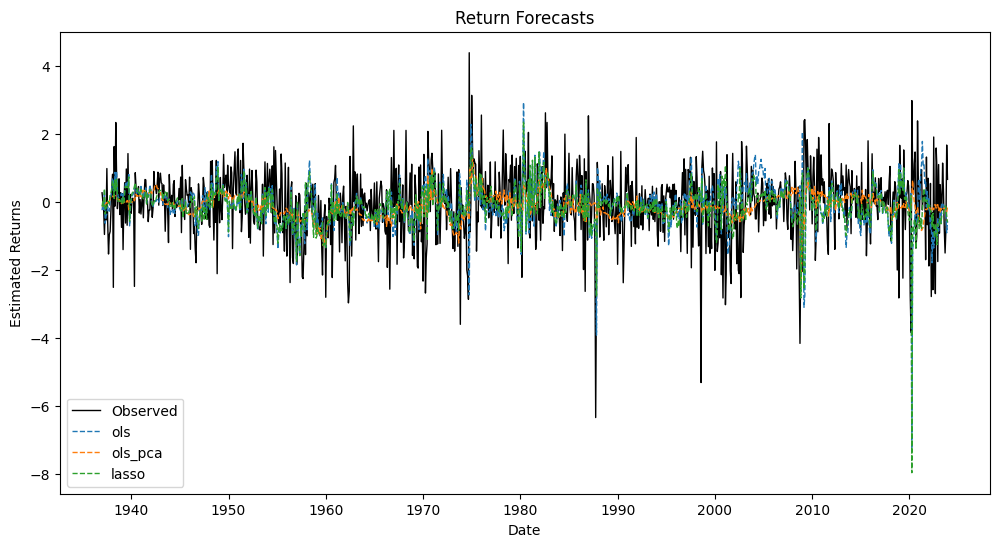

In [23]:
# Load the data
df = load_data()

df = transxf(df)

# Preprocess the data
df = preprocess_data(df)

# Define initial training window size
initial_window_size = 120

# Initialize lists to store forecasts and actual values
forecast_results = {
    'ols': [],
    'ols_pca': [],
    'lasso': []
}

actual_values = []
test_indices = []


# Loop over the time steps
for t in range(initial_window_size, len(df)-1):

    # Get training data up to time t
    train_data = df.iloc[t-initial_window_size:t].copy()

    # Get test data at time t+1
    test_data = df.iloc[t:t+1].copy()

    # Check for NaN in train_data or test_data, skip if necessary
    if train_data.isnull().values.any() or test_data.isnull().values.any():
        continue  # Skip this iteration if there are NaN values

    # Scaling
    scaler = StandardScaler()
    train_data_scaled = pd.DataFrame(scaler.fit_transform(train_data), index=train_data.index, columns=train_data.columns)
    test_data_scaled = pd.DataFrame(scaler.transform(test_data), index=test_data.index, columns=test_data.columns)

    # Apply PCA
    pca = PCA(n_components=3, whiten=True, svd_solver='full')
    pca.fit(train_data_scaled.drop("Target", axis=1))

    train_pca = pd.DataFrame(pca.transform(train_data_scaled.drop("Target", axis=1)), index=train_data_scaled.index)
    test_pca = pd.DataFrame(pca.transform(test_data_scaled.drop("Target", axis=1)), index=test_data_scaled.index)

    # Train models
    models = train_models(train_data_scaled, train_pca, None)

    # Generate forecasts
    test_forecasts = generate_forecasts(models, test_data_scaled, test_pca)

    # Store forecasts
    for model_name in forecast_results.keys():
        forecast_results[model_name].append(test_forecasts[model_name][0])

    # Store actual value
    actual_values.append(test_data_scaled["Target"].values[0])

    # Store test index
    test_indices.append(test_data.index[0])

# Evaluate models
evaluate_models(forecast_results, actual_values)

# Plot forecasts
plot_forecasts(forecast_results, actual_values, test_indices)